# Zipf's Law Analysis

In [1]:
import chess
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from collections import Counter
import seaborn as sns
sns.set_theme()

Connection to database

In [2]:
conn = sqlite3.connect("chess_games.db")
cursor = conn.cursor()

## Zipf's Law for the moves

In [25]:
df = pd.read_sql_query("SELECT game_id, move FROM moves", conn)
# group by game_id 
len_games = df.groupby('game_id').size()
#drop column game_ids from the dataframe
#remove the last character if the move has five characters to exclude differences in promotions
df['move'] = df['move'].str[:-1].where(df['move'].str.len() == 5, df['move'])

In [26]:
len_games

game_id
1         198
2         147
3         118
4         267
5         237
         ... 
99996     163
99997     171
99998      82
99999     150
100000    129
Length: 100000, dtype: int64

In [27]:
# Count the occurrences of each move
move_counts = Counter(df['move'].tolist())

# Sort the moves by frequency
sorted_move_counts = move_counts.most_common()
move_ranks = range(1, len(sorted_move_counts) + 1)
move_frequencies = [count for fen, count in sorted_move_counts]


Plot the Zipf's Law for moves

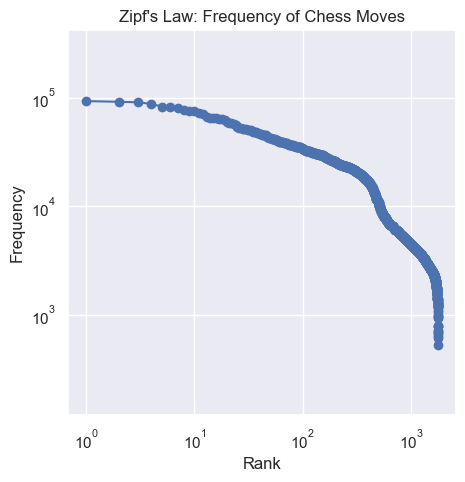

In [28]:
plt.figure(figsize=(5, 5))
plt.loglog(move_ranks, move_frequencies, marker='o')
plt.title("Zipf's Law: Frequency of Chess Moves")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.axis('equal') 
plt.show()


### Compute the exponent of the Zipf's Law 

$f(r) = \frac{C}{r^s}$

where f(r) is the frequency of the word at rank r, C is a constant, and s is the Zipf exponent.

The Zipf's exponent is useful for analysis since:
- s<1: The distribution flattens. Frequencies are more evenly spread across ranks, indicating a more uniform distribution of items.
- s=1: The classic Zipfian case. The second-ranked item occurs half as frequently as the first, and so on. This implies that a few words are extremely common, and many are rare.
- s>1: The distribution is steeper.
    High-ranked items dominate, and lower-ranked items become significantly rare. 
    This suggests a system where a few elements are overwhelmingly prevalent.



In [29]:
log_move_ranks = np.log(move_ranks)
log_move_freqs = np.log(move_frequencies)
move_coeffs = np.polyfit(log_move_ranks, log_move_freqs, 1)
move_slope = move_coeffs[0]
print(f"Estimated Zipf exponent for moves: {abs(move_slope):.2f}")

Estimated Zipf exponent for moves: 0.90


This exponent is extremely similar to a natural language!
Let's try to compare it to a natural language taking the Zipf's law exponent of some Shakespear's writings as a benchmark

In [30]:
import os
# load  all the writings from shakespeare
path = "data/shakespearWritings"
doc = ""
for filename in os.listdir(path):
    if filename.endswith(".txt"):
        with open(os.path.join(path, filename), "r") as file:
            doc += file.read() + " "

Tokenization

In [31]:
shakespearWritings = doc.split()


Zipf's Law

In [32]:
word_counts = Counter(shakespearWritings)
# Sort the words by frequency
sorted_word_counts = word_counts.most_common()
word_ranks = range(1, len(sorted_word_counts) + 1)
word_frequencies = [count for word, count in sorted_word_counts]


Plot

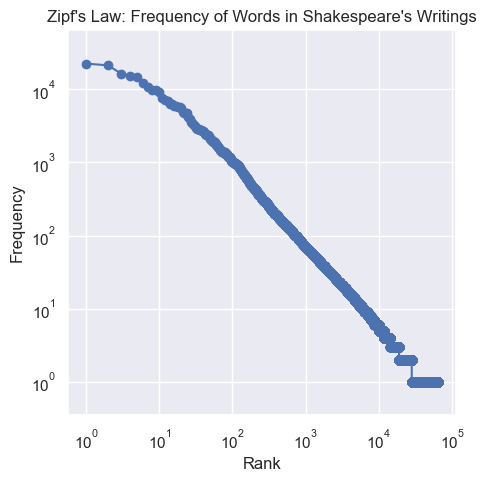

In [33]:
plt.figure(figsize=(5, 5))
plt.loglog(word_ranks, word_frequencies, marker='o')
plt.title("Zipf's Law: Frequency of Words in Shakespeare's Writings")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.axis('equal')
plt.show()

Zipf's Law Exponent

In [34]:
log_word_ranks = np.log(word_ranks)
log_word_freqs = np.log(word_frequencies)
word_coeffs = np.polyfit(log_word_ranks, log_word_freqs, 1)
word_slope = word_coeffs[0]
print(f"Estimated Zipf exponent in Shakespear's writings: {abs(word_slope):.2f}")

Estimated Zipf exponent in Shakespear's writings: 1.09


Compare on the same plot the chess plot and the Shakespear one

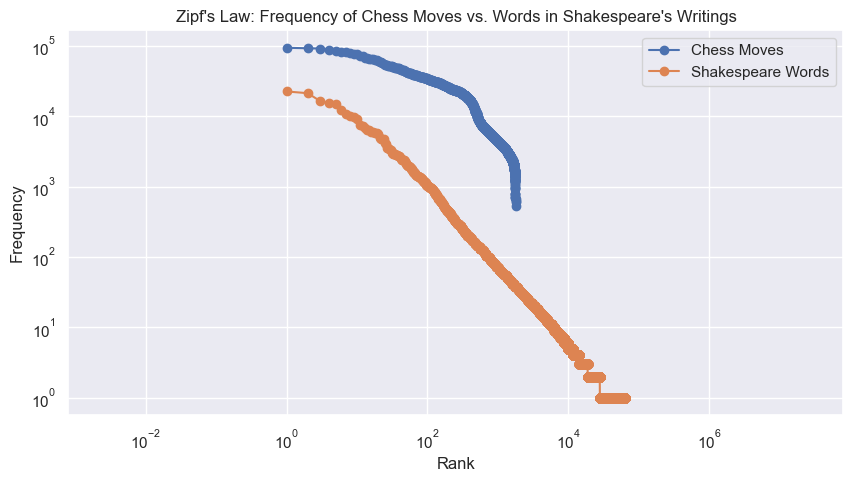

In [35]:
#Compare on the same plot the chess plot and the Shakespear one
plt.figure(figsize=(10, 5))
plt.loglog(move_ranks, move_frequencies, marker='o', label="Chess Moves")
plt.loglog(word_ranks, word_frequencies, marker='o', label="Shakespeare Words")
plt.title("Zipf's Law: Frequency of Chess Moves vs. Words in Shakespeare's Writings")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.axis('equal')
plt.show()

## Zipf's Law for the moves depending on phase of the game

Divide the moves in:
- 10%: opening
- 30%:  midgame
- 31+: endgame

In [36]:
def classify_phase(move_number,game_id):
    if move_number <= 0.1*len_games[game_id]:
        return 'opening'
    elif move_number <= 0.3*len_games[game_id]:
        return 'midgame'
    else:
        return 'endgame'


In [38]:
df = pd.read_sql_query("SELECT game_id, move_number, move FROM moves", conn)

#df["phase"] = df["move_number"].apply(classify_phase)
# Create a new column 'phase' based on the move number
df["phase"] = df.apply(lambda row: classify_phase(row["move_number"], row["game_id"]), axis=1)

phase_groups = df.groupby("phase")["move"].apply(list)


Method to plot Zipf's Law for every phase

In [39]:
def zipf_plot(move_list, phase_name):
    counter = Counter(move_list)
    frequencies = np.array(sorted(counter.values(), reverse=True))
    ranks = np.arange(1, len(frequencies) + 1)

    plt.plot(np.log(ranks), np.log(frequencies), label=phase_name)
    
    coeffs = np.polyfit(np.log(ranks), np.log(frequencies), 1)
    print(f"{phase_name.capitalize()} Zipf exponent: {-coeffs[0]:.2f}")

Endgame Zipf exponent: 1.18
Midgame Zipf exponent: 1.44
Opening Zipf exponent: 2.16


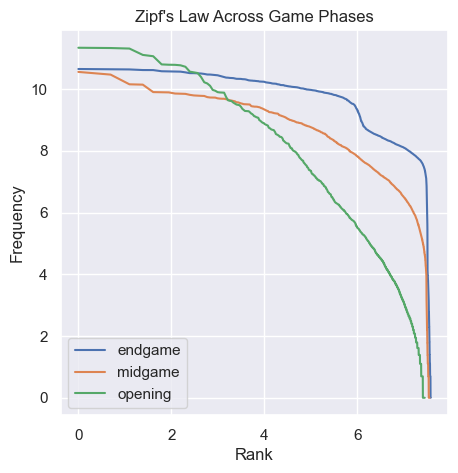

In [40]:
plt.figure(figsize=(5, 5))
for phase, moves in phase_groups.items():
    zipf_plot(moves, phase)

plt.title("Zipf's Law Across Game Phases")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.show()

At this point, since the exponent it's higher in the opening phase due to openings, it is interesting to investigate when the exponent gets close to one during games to try to find the lenght of openings (if the  exponent is close to one there are no few prevalent elements).

In [17]:
# Group the data by move_number
df_grouped = df.groupby('move_number')['move'].apply(list).reset_index()

Move 43 Zipf exponent: 1.45


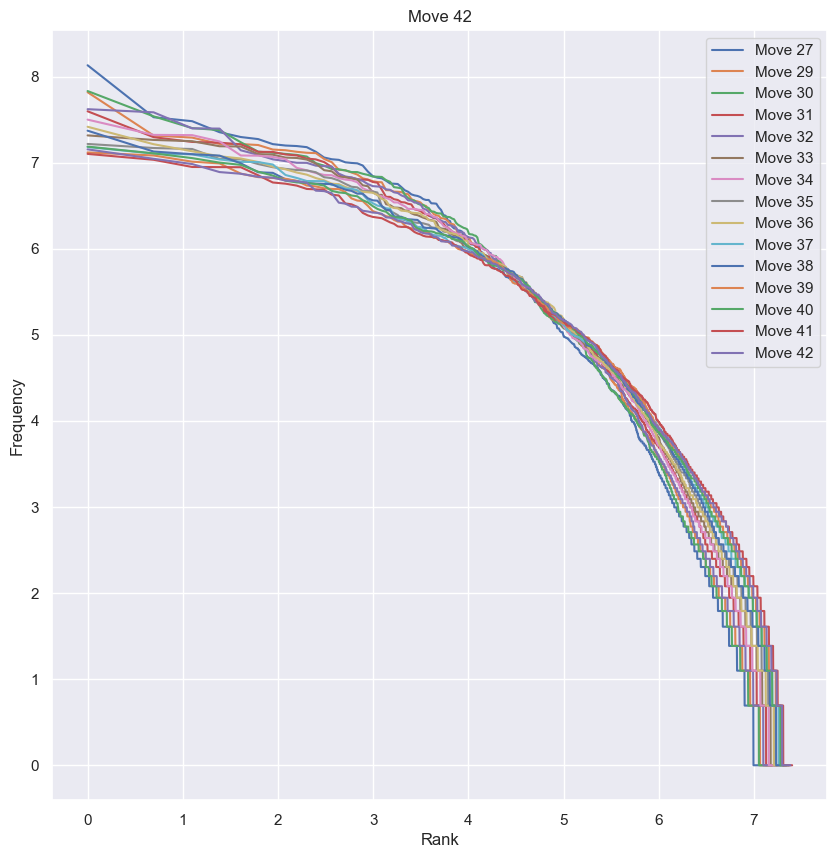

In [18]:
#loop through each move_number and plot the Zipf's law until exp - 1 < threshold
threshold = 0.5

plt.figure(figsize=(10, 10))


for index, row in df_grouped.iterrows():
    move_list = row['move']
    counter = Counter(move_list)
    frequencies = np.array(sorted(counter.values(), reverse=True))
    ranks = np.arange(1, len(frequencies) + 1)
    coeffs = np.polyfit(np.log(ranks), np.log(frequencies), 1)
    if abs(coeffs[0])-1 < threshold:
        break
    #plot just the ones with Zipf exponent <2
    if abs(coeffs[0]) < 1.8:
        plt.title(f"Move {row['move_number']}")
        plt.plot(np.log(ranks), np.log(frequencies), label=f"Move {row['move_number']}")
        plt.xlabel("Rank")
        plt.ylabel("Frequency")
        plt.legend()

print(f"Move {row['move_number']} Zipf exponent: {-coeffs[0]:.2f}")


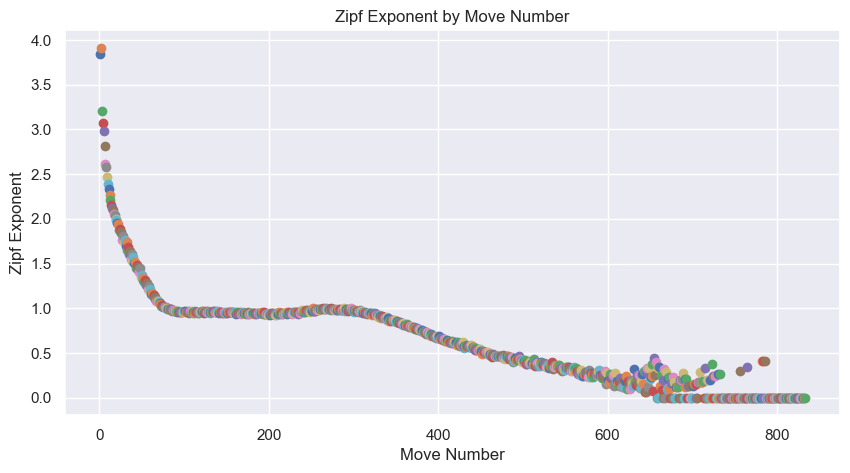

In [42]:
#  calculate the  Zipf exponent for each move_number and  plot the results
plt.figure(figsize=(10, 5))
zipf_exponents = []
for index, row in df_grouped.iterrows():
    move_list = row['move']
    counter = Counter(move_list)
    frequencies = np.array(sorted(counter.values(), reverse=True))
    ranks = np.arange(1, len(frequencies) + 1)
    coeffs = np.polyfit(np.log(ranks), np.log(frequencies), 1)
    zipf_exponents.append(-coeffs[0])
    plt.plot(row['move_number'], zipf_exponents[-1], 'o', label=f"Move {row['move_number']}")
plt.title("Zipf Exponent by Move Number")
plt.xlabel("Move Number")
plt.ylabel("Zipf Exponent")
plt.show()

In [19]:
df = pd.read_sql_query("SELECT game_id, move_number, move FROM moves", conn)


In [20]:
#count the number of moves in each game
df['move_count'] = df.groupby('game_id')['move'].transform('count')
df['move_count'] = df['move_count'].astype(int)

In [21]:
df.drop_duplicates(subset=['game_id', 'move_count'], inplace=True)
df.drop(columns=['move_number', 'move'], inplace=True)
df

,game_id,move_count
0,1,198
198,2,147
345,3,118
463,4,267
730,5,237
...,...,...
18951038,99996,163
18951201,99997,171
18951372,99998,82
18951454,99999,150
